# Step 1: Cloning and Building Darknet


In [2]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 14691, done.
remote: Total 14691 (delta 0), reused 0 (delta 0), pack-reused 14691
Receiving objects: 100% (14691/14691), 13.26 MiB | 24.08 MiB/s, done.
Resolving deltas: 100% (9995/9995), done.


In [3]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [4]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [5]:
# make darknet (build)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

# Step 2: Download pretrained YOLOv3 weights


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# get yolov3 pretrained coco dataset weights
# !wget https://pjreddie.com/media/files/yolov3.weights
!cp '/content/drive/MyDrive/VinBigData/CV_final project/yolo/yolov3.weights' '/content/darknet'

In [7]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

# Training a Custom YOLOv3 Object Detector in the Cloud!

In order to create a custom YOLOv3 detector we will need the following:

*   Labeled Custom Dataset
*   Custom .cfg file
*   obj.data and obj.names files
*   train.txt file (test.txt is optional here as well)


# Step 1: Gathering and Labeling a Custom Dataset


# Step 2: Moving Your Custom Dataset Into Your Cloud VM
### Training dataset with arguments

In [ ]:
!cp -a '/content/drive/MyDrive/3. CV/Final project/dataset/data_with_label/label_20201201/train_label/.' '/content/darknet/data/train'
!cp -a '/content/drive/MyDrive/3. CV/Final project/dataset/image_20201201/train/.' '/content/darknet/data/train'

### Training dataset without argument

In [ ]:
!cp -a '/content/drive/MyDrive/VinBigData/CV_final project/dataset/data_with_label/label_20201201/train_label_without_argument/.' '/content/darknet/data/train_without_argument'
!cp -a '/content/drive/MyDrive/VinBigData/CV_final project/dataset/image_20201201/train_without_argument/.' '/content/darknet/data/train_without_argument'

### Testing *dataset*

In [33]:
!cp -a '/content/drive/MyDrive/VinBigData/CV_final project/dataset/data_with_label/label_20201201/test_label/.' '/content/darknet/data/test'
# !cp -a '/content/drive/MyDrive/VinBigData/CV_final project/dataset/image_20201201/test/.' '/content/darknet/data/test'

# Step 3: Configuring Files for Training
This step involves properly configuring your custom .cfg file, obj.data, obj.names and train.txt file.
## i) Cfg File
Copy over the yolov3.cfg to edit by running the cell below.

I recommend having **batch = 64** and **subdivisions = 16** for ultimate results. If you run into any issues then up subdivisions to 32.

Make the rest of the changes to the cfg based on how many classes you are training your detector on.

**Note:** I set my **max_batches = 500**, **steps = 400, 450**, I changed the **classes = 1** in the three YOLO layers and **filters = (1+5)*3 = 18** in the three convolutional layers before the YOLO layers. 

**Optional:** In each of the three yolo layers in the cfg, change one line from random = 1 to **random = 0** to speed up training but slightly reduce accuracy of model. Will also help save memory if you run into any memory issues.

In [7]:
# download cfg to google drive and change its name
!cp '/content/drive/MyDrive/VinBigData/CV_final project/yolo/yolov3_custom.cfg' '/content/darknet/cfg'

## ii) obj.names and obj.data 
Create a new file within a code or text editor called **obj.names** and you will make this file exactly the same as your classes.txt in the dataset generation step.

*obj.names*

```
ruler
```




You will also create a **obj.data** file and fill it in like this (change your number of classes accordingly, as well as your backup location)

*obj.data*

```
classes = 1
train = data/train.txt
valid = data/test.txt
names = data/obj.names
backup = backup/
```





This backup path is where we will save the weights to of our model throughout training. Create a backup folder in your google drive and put its correct path in this file.

In [14]:
# upload the obj.names and obj.data files to cloud VM from Google Drive
!cp '/content/drive/MyDrive/VinBigData/CV_final project/yolo/obj.names' './data'
!cp '/content/drive/MyDrive/VinBigData/CV_final project/yolo/obj.data' './data'


## iii) Generating train.txt
The last configuration file needed before we can begin to train our custom detector is the train.txt file which hold the relative paths to all our training images.

In [ ]:
%cd /content/darknet
%ls

/content/darknet
3rdparty/               darknet.py              obj/
backup/                 darknet_video.py        predictions.jpg
build/                  data/                   README.md
build.ps1*              image_yolov3.sh*        results/
build.sh*               image_yolov4.sh*        scripts/
cfg/                    include/                src/
cmake/                  json_mjpeg_streams.sh*  video_yolov3.sh*
CMakeLists.txt          LICENSE                 video_yolov4.sh*
darknet*                Makefile                yolov3.weights
DarknetConfig.cmake.in  net_cam_v3.sh*
darknet_images.py       net_cam_v4.sh*


In [ ]:
#generate_train
import os

image_files = []
train_path = 'data/train_without_argument'

os.chdir(train_path)
for filename in os.listdir(os.getcwd()):
    if filename.endswith(".jpg"):
        image_files.append(os.path.join(train_path, filename))
os.chdir("..")
with open("train.txt", "w") as outfile:
    for image in image_files:
        outfile.write(image)
        outfile.write("\n")
    outfile.close()
os.chdir("..")

# Step 4: Download pre-trained weights for the convolutional layers.


In [ ]:
# upload pretrained convolutional layer weights
# !wget http://pjreddie.com/media/files/darknet53.conv.74

!cp '/content/drive/MyDrive/VinBigData/CV_final project/yolo/darknet53.conv.74' '/content/darknet'


# Step 5: Train Your Custom Object Detector!


In [ ]:
# train your custom detector
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg darknet53.conv.74 -dont_show

Streaming output truncated to the last 5000 lines.
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.439917), count: 4, class_loss = 1.141484, iou_loss = 1.559324, total_loss = 2.700808 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.001808, iou_loss = 0.000000, total_loss = 0.001808 
 total_bbox = 22964, rewritten_bbox = 0.000000 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.000000), count: 1, class_loss = 0.002143, iou_loss = 0.000000, total_loss = 0.002143 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.423641), count: 3, class_loss = 0.931505, iou_loss = 1.346976, total_loss = 2.278481 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.001938, iou_loss = 0.000000, total_loss = 0.001938 
 total_bbox = 22967, rewritten_bbox = 0.000000 % 
v3 (mse

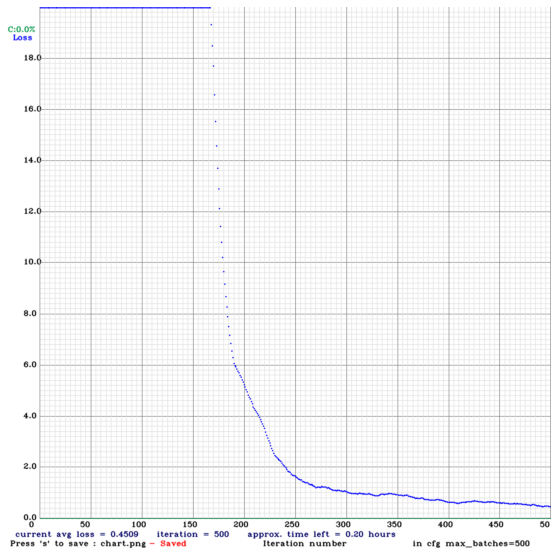

In [ ]:
imShow('chart.png')

In [ ]:
#backup weights
!cp -r '/content/darknet/backup' '/content/drive/MyDrive/3. CV/Final project/yolo'

# Step 6: Run Your Custom Object Detector!!!


In [ ]:
# need to set our custom cfg to test mode 
# %cd cfg
# !sed -i 's/batch=64/batch=1/' yolov3_custom2.cfg
# !sed -i 's/subdivisions=16/subdivisions=1/' yolov3_custom2.cfg
# %cd ..

In [12]:
!cp '/content/drive/MyDrive/VinBigData/CV_final project/yolo/yolov3_custom2.cfg' '/content/darknet/cfg'

In [9]:
!cp -r '/content/drive/MyDrive/VinBigData/CV_final project/dataset/image_20201201/test' '/content/darknet/data'

In [26]:
#generate_test
import os

image_files = []
train_path = 'data/test'

os.chdir(train_path)
for filename in os.listdir(os.getcwd()):
    if filename.endswith(".jpg"):
        image_files.append(os.path.join(train_path, filename))
os.chdir("..")
with open("test.txt", "w") as outfile:
    for image in image_files:
        outfile.write(image)
        outfile.write("\n")
    outfile.close()
os.chdir("..")

In [10]:
#copy weight
!cp -a '/content/drive/MyDrive/VinBigData/CV_final project/yolo/weight_with_argument/.' '/content/darknet/backup'

### Test with an image


 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 B

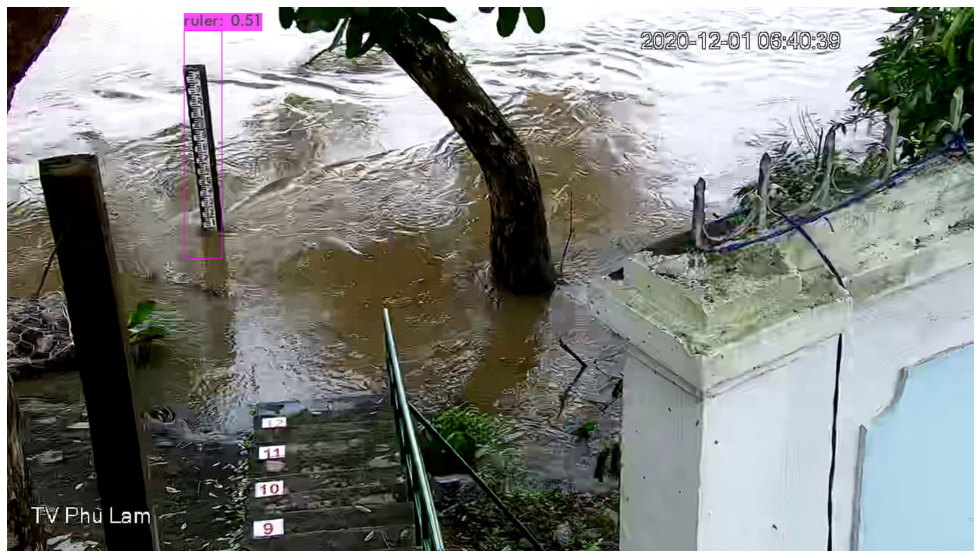

In [30]:
!./darknet detector test data/obj.data cfg/yolov3_custom2.cfg /content/darknet/backup/yolov3_custom_final.weights -dont_show -ext_output /content/darknet/data/test/img_20201201_34.jpg result.txt #-thresh 0.5 
imShow('predictions.jpg')

### Test with a video - Real time


In [14]:
!cp '/content/drive/MyDrive/VinBigData/CV_final project/dataset/v_20201201_0.mp4' '/content/darknet/data/video'

In [16]:
!./darknet detector demo data/obj.data cfg/yolov3_custom2.cfg /content/darknet/backup/yolov3_custom_final.weights -dont_show /content/darknet/data/video/v_20201201_0.mp4 -i 0 -out_filename output.mp4 -thresh 0.4

Streaming output truncated to the last 5000 lines.
 cvWriteFrame 
Objects:

ruler: 48% 

FPS:32.5 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

ruler: 62% 

FPS:33.2 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:


FPS:32.3 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

ruler: 45% 

FPS:31.4 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:


FPS:32.0 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

ruler: 52% 
ruler: 49% 

FPS:33.4 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

ruler: 49% 
ruler: 48% 

FPS:33.9 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

ruler: 46% 

FPS:32.9 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

ruler: 58% 

FPS:33.2 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

ruler: 57% 

FPS:33.7 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

ruler: 43% 

FPS:34.7 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

ruler: 55% 

FPS:33.8 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

ruler: 58% 

FPS:34.6 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

ruler: 66% 

FPS:34.9 	 AVG_FPS:0.0

 cvWriteFrame 
Objects:

ruler: 58% 

FPS:36.5 	 AVG_FPS:0.0

 cvWriteFrame 
Obje

In [ ]:
!cp '/content/darknet/output.avi' '/content/drive/MyDrive/3. CV/Final project/yolo/result'

In [34]:
!./darknet detector map data/obj.data cfg/yolov3_custom2.cfg /content/darknet/backup/yolov3_custom_final.weights

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 B

In [35]:
!./darknet detector recall data/obj.data cfg/yolov3_custom2.cfg /content/darknet/backup/yolov3_custom_final.weights

 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x 128 0.001 B